In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp

/tmp/ipykernel_3081039/2492120434.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
from collections import defaultdict
import time
import json

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_3081039/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [9]:
import spikeinterface.full as si

In [10]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- Please look at this website to see which importing method matches your data format. https://spikeinterface.readthedocs.io/en/latest/modules/extractors/plot_1_read_various_formats.html#sphx-glr-modules-extractors-plot-1-read-various-formats-py
- You can also try tab completing `se.read_` and see what other electrophysiology data formats are accepted
    - All the different options for importing electrophysiology data:

In [11]:
for method in dir(se):
    if method.startswith("read"):
        print(method)

read_alf_sorting
read_alphaomega
read_alphaomega_event
read_axona
read_bids
read_biocam
read_blackrock
read_blackrock_sorting
read_cbin_ibl
read_ced
read_combinato
read_edf
read_hdsort
read_herdingspikes
read_intan
read_kilosort
read_klusta
read_maxwell
read_maxwell_event
read_mclust
read_mcsh5
read_mcsraw
read_mda_recording
read_mda_sorting
read_mearec
read_neuralynx
read_neuralynx_sorting
read_neuroscope
read_neuroscope_recording
read_neuroscope_sorting
read_nix
read_nwb
read_nwb_recording
read_nwb_sorting
read_openephys
read_openephys_event
read_phy
read_plexon
read_shybrid_recording
read_shybrid_sorting
read_spike2
read_spikegadgets
read_spikeglx
read_spykingcircus
read_tdt
read_tridesclous
read_waveclus
read_waveclus_snippets
read_yass


- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

In [12]:
# Getting all the file paths of the recording files(that happen to all end in `.txt`)
all_recording_files = glob.glob("./data/**/*.rec", recursive=True)

In [13]:
all_recording_files

['./data/20221215_145401_comp_amd_om_6_1_top_4_base_3.rec']

- If you have more than one recording file, then you must either:
    - A. Put the index of the file in `all_recording_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `open({./path/to/recording_file.rec})` below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

- Reading in the data into Spikeinterface
    - **NOTE**: If you are not using Spikegadgets to record your electrophysiological data, then you must change the `read_spikegadgets` below to the format/device that you are using. Look at list above to see which one matches yours.  

In [14]:
trodes_recording = se.read_spikegadgets(all_recording_files[0], stream_id="trodes")

## Metadata from the recording file

This is how you retrieve info from a :code:`RecordingExtractor`...



In [15]:
channel_ids = trodes_recording.get_channel_ids()
fs = trodes_recording.get_sampling_frequency()
num_chan = trodes_recording.get_num_channels()
num_seg = trodes_recording.get_num_segments()
duration = trodes_recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 66692532
Number of hours: 0.9262851666666667


# Importing the ECU Data

In [16]:
ECU_recording = se.read_spikegadgets(all_recording_files[0], stream_id="ECU")

In [17]:
channel_ids = ECU_recording.get_channel_ids()
fs = ECU_recording.get_sampling_frequency()
num_chan = ECU_recording.get_num_channels()
num_seg = ECU_recording.get_num_segments()
duration = ECU_recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['ECU_Ain1' 'ECU_Ain2' 'ECU_Ain3' 'ECU_Ain4' 'ECU_Ain5' 'ECU_Ain6'
 'ECU_Ain7' 'ECU_Ain8' 'ECU_Aout1' 'ECU_Aout2' 'ECU_Aout3' 'ECU_Aout4']
Sampling frequency: 20000.0
Number of channels: 12
Number of segments: 1
Duration: 66692532
Number of hours: 0.9262851666666667


## Metadata from the recording file

This is how you retrieve info from a :code:`RecordingExtractor`...



In [18]:
channel_ids = trodes_recording.get_channel_ids()
fs = trodes_recording.get_sampling_frequency()
num_chan = trodes_recording.get_num_channels()
num_seg = trodes_recording.get_num_segments()
duration = trodes_recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 66692532
Number of hours: 0.9262851666666667


In [19]:
recording = trodes_recording

## Plotting the electrophysiology activity

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc.
Let's use the :code:`widgets` module to visualize the traces and the raster plots.



- Plotting the activity for all channels for the first 5 seconds
    - Check to see if there's any activity.
    - You can adjust the time by changing `time_range=(0, 5)`. The first number is when the plotting starts in seconds, and the second number is the when the plotting ends.

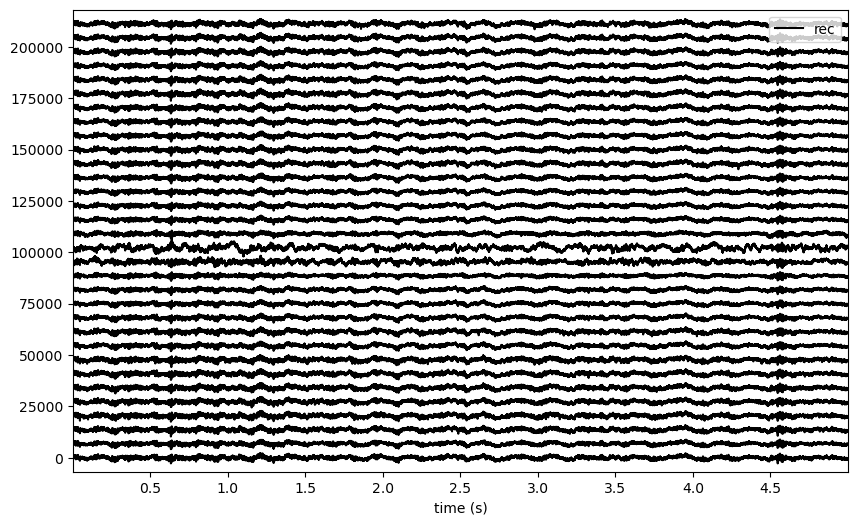

In [20]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))


# Part 2: Setting Probes

In [21]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

- Adding the information about the probes used to record the electrophysiology data.
- If you are using different probes, take a look at:
    - https://probeinterface.readthedocs.io/_/downloads/en/latest/pdf/
    - https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_3_handle_probe_info.html#sphx-glr-modules-core-plot-3-handle-probe-info-py

## Reading in a Probe file

In [22]:
# Getting all the file paths of the recording parameter files(that happen to all end in `.prm`)
all_probe_files = glob.glob("./data/*nancy*.prb")

In [23]:
all_probe_files

['./data/nancyprobe_linearprobelargespace.prb']

- If you have more than one metadata file, then you must either:
    - A. Put the index of the file in `all_parameter_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `open({./path/to/recording_file.rec})` below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [24]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    probe_parameters = imp.load_source("probe_parameters", all_probe_files[0])
    with open(all_probe_files[0]) as info_file:
        lines = info_file.readlines()
        for line in lines:
            print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

- Reading in the probe information into Spike interface and plotting the probe

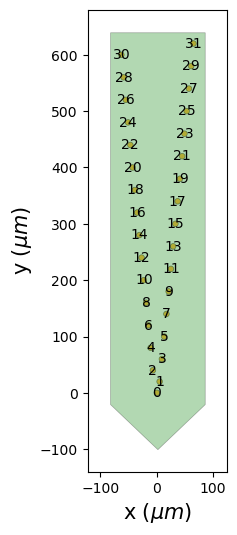

In [25]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    # Reading in the probe data
    probe_object = read_prb(all_probe_files[0])
    # Setting the probe to the recording object
    recording = recording.set_probes(probe_object)
    # Plotting the probe configuration
    plot_probe_group(probe_object, same_axes=True, with_channel_index=True)
    plt.show()

In [26]:

probe_object.to_dataframe()

,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0,0.0,0.0,circle,5.0,,
1,0,5.0,20.0,circle,5.0,,
2,0,-7.0,40.0,circle,5.0,,
3,0,9.0,60.0,circle,5.0,,
4,0,-11.0,80.0,circle,5.0,,
5,0,13.0,100.0,circle,5.0,,
6,0,-15.0,120.0,circle,5.0,,
7,0,17.0,140.0,circle,5.0,,
8,0,-19.0,160.0,circle,5.0,,
9,0,21.0,180.0,circle,5.0,,


In [27]:
probe_object.get_global_contact_ids()

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype='<U64')

In [28]:
probe_object.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (0,  4), (0,  5), (0,  6),
       (0,  7), (0,  8), (0,  9), (0, 10), (0, 11), (0, 12), (0, 13),
       (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20),
       (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27),
       (0, 28), (0, 29), (0, 30), (0, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

- Creating a dictionary of all the variables in the probe file

In [29]:
if 'probe_parameters' in locals():
    probe_dict = defaultdict(dict)
    for attribute in dir(probe_parameters):
        # Removing built in attributes
        if not attribute.startswith("__"): 
            probe_dict[attribute] = getattr(probe_parameters, attribute)

In [30]:
if "probe_dict" in locals():
    for key, value in probe_dict.items():
        print("{}: {}".format(key, value))

channel_groups: {0: {'channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'geometry': {0: (0, 0), 1: (5, 20), 2: (-7, 40), 3: (9, 60), 4: (-11, 80), 5: (13, 100), 6: (-15, 120), 7: (17, 140), 8: (-19, 160), 9: (21, 180), 10: (-23, 200), 11: (25, 220), 12: (-27, 240), 13: (29, 260), 14: (-31, 280), 15: (33, 300), 16: (-35, 320), 17: (37, 340), 18: (-39, 360), 19: (41, 380), 20: (-43, 400), 21: (45, 420), 22: (-47, 440), 23: (49, 460), 24: (-51, 480), 25: (53, 500), 26: (-55, 520), 27: (57, 540), 28: (-59, 560), 29: (61, 580), 30: (-63, 600), 31: (65, 620)}, 'graph': [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31)]}}


# Part 2.1 Making a probe from scratch

## NOTE: If you do not have a probe file, you must make a probe from scratch

In [31]:
import itertools

In [32]:
from probeinterface import Probe, ProbeGroup
from probeinterface import Probe
from probeinterface.plotting import plot_probe_group
from probeinterface.plotting import plot_probe

In [33]:
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface.generator import generate_tetrode
from probeinterface.generator import generate_linear_probe
from probeinterface.generator import generate_multi_columns_probe

- Making 8 tetrodes for 32 channels

In [34]:
probegroup = ProbeGroup()
# The difference in position for the X and Y axis of all the tetrodes
x_difference = [0, 40, 80, 120]
y_difference = [0, 40]
# Getting a combination of all the X and Y differences
difference_combinations = list(itertools.product(x_difference, y_difference))

for num in range(8):   
    # Creating a new tetrode
    current_tetrode = generate_tetrode()
    # Moving the tetrode
    current_tetrode.move([difference_combinations[num][0], difference_combinations[num][1]])
    # Adding the tetrode to the group
    probegroup.add_probe(current_tetrode)

# Setting the indices of the channels
probegroup.set_global_device_channel_indices(np.arange(32))

In [35]:
# Number of channels
probegroup.get_channel_count()

32

In [36]:
# The IDs of the probes/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls
probegroup.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (1,  4), (1,  5), (1,  6),
       (1,  7), (2,  8), (2,  9), (2, 10), (2, 11), (3, 12), (3, 13),
       (3, 14), (3, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 20),
       (5, 21), (5, 22), (5, 23), (6, 24), (6, 25), (6, 26), (6, 27),
       (7, 28), (7, 29), (7, 30), (7, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

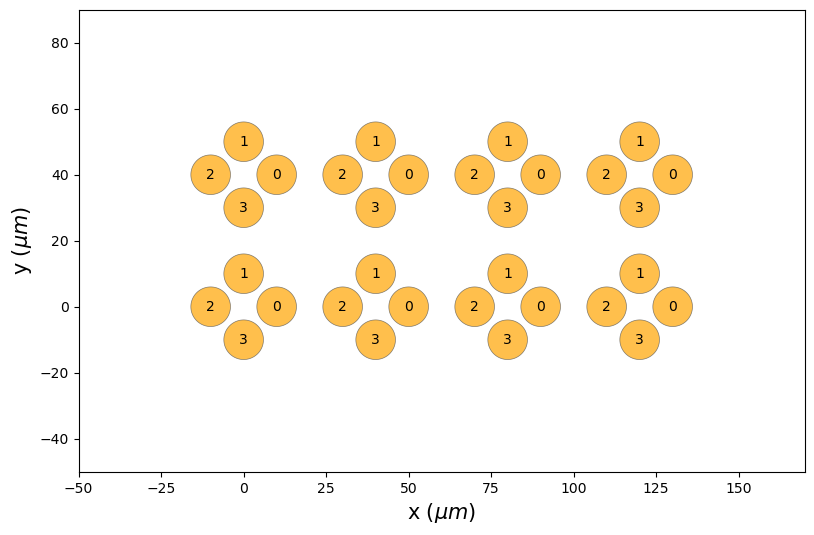

In [37]:
# What all the probes look like
plot_probe_group(probegroup, same_axes=True, with_channel_index=True)

In [38]:
# The X and Y position of the probes
probegroup.to_dataframe().head(n=12)

,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0,1.000000e+01,0.000000e+00,circle,6.0,,
1,0,6.123234e-16,1.000000e+01,circle,6.0,,
2,0,-1.000000e+01,1.224647e-15,circle,6.0,,
3,0,-1.836970e-15,-1.000000e+01,circle,6.0,,
4,1,1.000000e+01,4.000000e+01,circle,6.0,,
5,1,6.123234e-16,5.000000e+01,circle,6.0,,
6,1,-1.000000e+01,4.000000e+01,circle,6.0,,
7,1,-1.836970e-15,3.000000e+01,circle,6.0,,
8,2,5.000000e+01,0.000000e+00,circle,6.0,,
9,2,4.000000e+01,1.000000e+01,circle,6.0,,


- Uncomment this if you want to use the tetrodes as the probes instead

### Multishank Probe

In [39]:
multi_shank = generate_multi_shank(num_shank=32, num_columns=1, num_contact_per_column=1)

(<matplotlib.collections.PolyCollection at 0x7fc18e0fd880>,
 <matplotlib.collections.PolyCollection at 0x7fc18dfd02e0>)

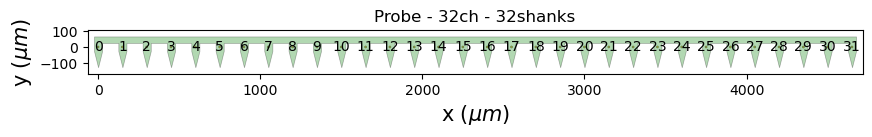

In [40]:
plot_probe(multi_shank, with_channel_index=True)

In [41]:
multi_shank.set_device_channel_indices(np.arange(num_chan))

- Turn the cell below into a code block if you want to use the multishank probes as the probes instead

# Creating my own probe

In [42]:
from probeinterface import combine_probes

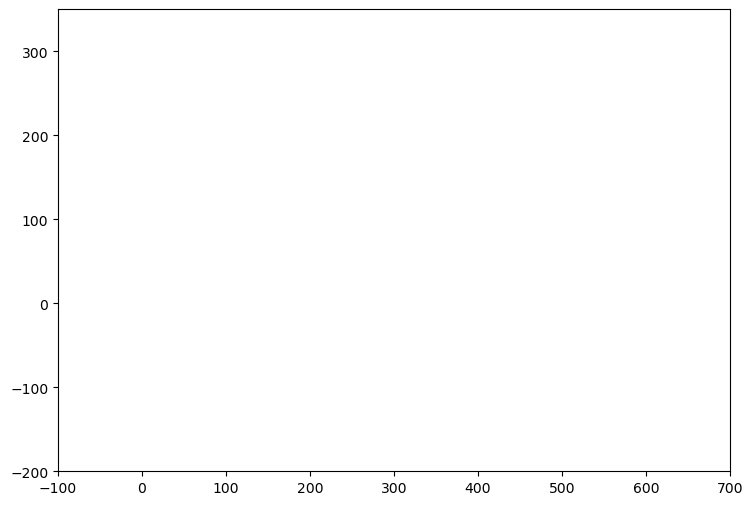

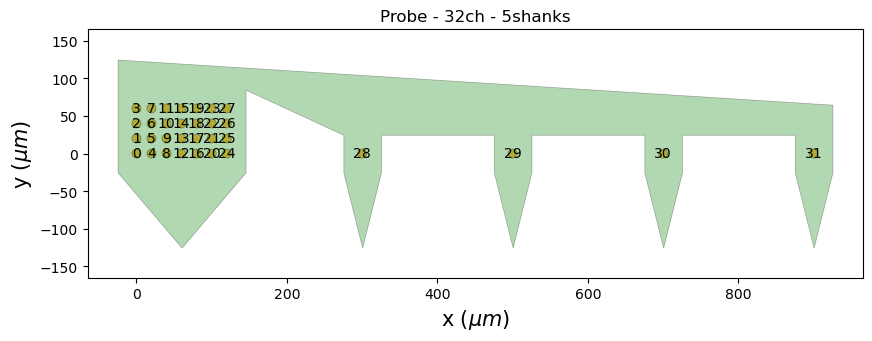

In [43]:
fig, ax = plt.subplots()

probe_mPFC = generate_multi_columns_probe(num_columns=7, num_contact_per_column=4)
# plot_probe(probe0, ax=ax)

probe_lh = generate_linear_probe(num_elec=1)
probe_lh.move([300, 0])
# plot_probe(probe_lh, ax=ax, with_channel_index=True)

probe_bla = generate_linear_probe(num_elec=1)
probe_bla.move([500, 0])


probe_vHPC = generate_linear_probe(num_elec=1)
probe_vHPC.move([700, 0])

probe_md = generate_linear_probe(num_elec=1)
probe_md.move([900, 0])


multi_shank = combine_probes([probe_mPFC, probe_lh, probe_bla, probe_vHPC, probe_md])
plot_probe(multi_shank, with_channel_index=True)

ax.set_xlim(-100, 700)
ax.set_ylim(-200, 350)

ax.set_aspect('equal')

(<matplotlib.collections.PolyCollection at 0x7fc18de50d60>,
 <matplotlib.collections.PolyCollection at 0x7fc18ddb19a0>)

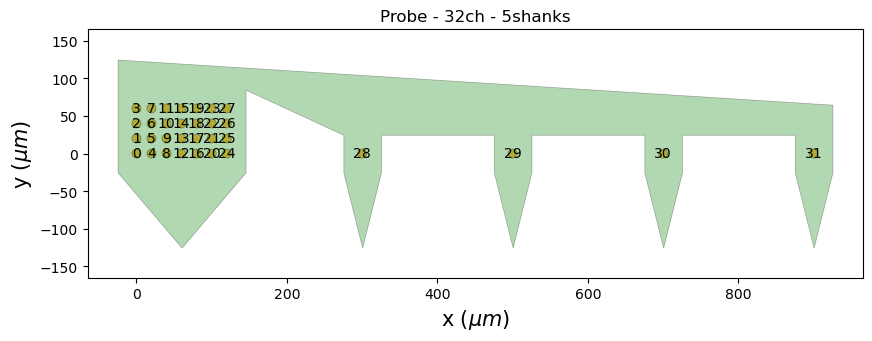

In [44]:
plot_probe(multi_shank, with_channel_index=True)


# Saving the Recording Files for the Next Notebook

- Creating an output folder based on the recording file name

In [45]:
recording_file_name = os.path.basename(all_recording_files[0])
recording_file_root = os.path.splitext(recording_file_name)[0]

In [46]:
recording_file_root = "subject_6_1_omission_and_competition_with_6_3"

In [47]:
recording_file_root

'subject_6_1_omission_and_competition_with_6_3'

- Alternatively, you can use the file name provided by the metadata file or the experiment name in the parameter file
    - If you want to use either of these, you must make the boxes below into a code block

In [48]:
parent_output_directory = "./proc/{}".format(recording_file_root)

In [49]:
os.makedirs(parent_output_directory, exist_ok=True)

In [50]:
recording_output_directory = os.path.join(parent_output_directory, "recording_raw")


In [51]:
recording_output_directory

'./proc/subject_6_1_omission_and_competition_with_6_3/recording_raw'

In [52]:
if not os.path.exists(recording_output_directory):
    recording.save_to_folder(name="recording_raw", folder=recording_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(recording_output_directory))

write_binary_recording with n_jobs = 1 and chunk_size = None
